<a href="https://colab.research.google.com/github/JefoGao/Python_TOR_NDA/blob/main/Appendix_IV/data_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Initialization

In [ ]:
%%shell
pip install tensorflow -q
pip install keras -q
pip install xgboost -q

In [ ]:
import gdown
import keras
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import sklearn
import tensorflow
import xgboost as xgb

from keras.wrappers.scikit_learn import KerasRegressor
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# 1 Predict Total Occupancy Rate

## 1.0 PCA

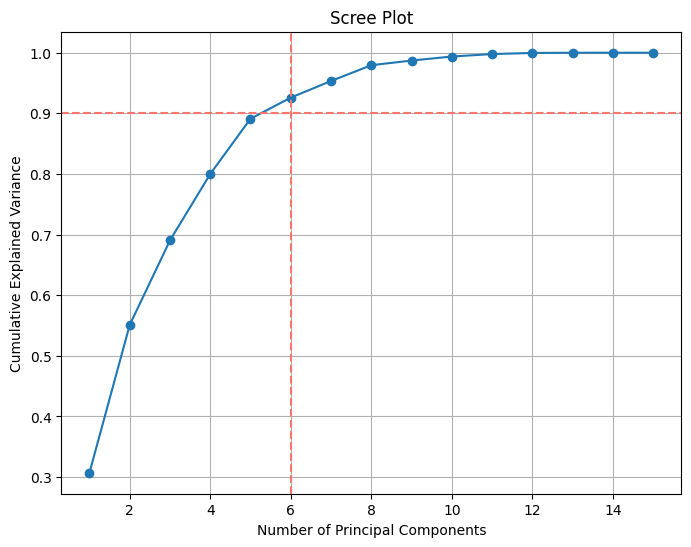

In [ ]:
# Load the dataset
data = pd.read_csv('communities_db.csv')

# Remove the target and non-numeric features
X_pca = data.drop(columns=['TotalOccupancyRate', 'State', 'Location', 'IsHighOccupancy'])

# Scale the features
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# Apply PCA
pca = PCA()
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Create a scree plot of explained variance ratios
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.9, linestyle='--', color='#f8766d') # line at 90% variance
plt.axvline(x=6, linestyle='--', color='#f8766d') 
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

In [ ]:
# Get the most important 6 features
n_features = 6
most_important_features = [np.abs(pca.components_[i]).argmax() for i in range(n_features)]
#most_important_features_set = list(set(most_important_features))
most_important_feature_names = [X_pca.columns[most_important_features[i]] for i in range(n_features)]

print("Most important features: ")
print(most_important_feature_names)

Most important features: 
['Prop2Bed', 'TotalHouseNo', 'WeightedFreq', 'PropDevi', 'Prop1Bed', 'MedianPrice']


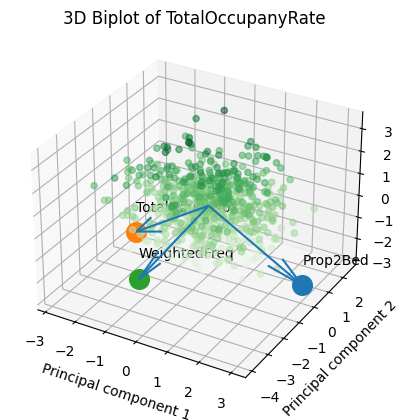

In [ ]:
# Load the dataset
data = pd.read_csv('communities_db.csv')

# Select the 3 most important features
important_features = ['Prop2Bed', 'TotalHouseNo', 'WeightedFreq']
X = data[important_features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=3)

# Fit and transform data
X_pca = pca.fit_transform(X_scaled)

# Create dataframe
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3'])

# Initialize the 3D graph
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define scaled features as arrays
xdata = pca_df['PC1']
ydata = pca_df['PC2']
zdata = pca_df['PC3']

# Plot 3D scatterplot of PCA
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens', alpha=0.5)

# Define the x, y, z variables
loadings = pca.components_
xs = loadings[0]
ys = loadings[1]
zs = loadings[2]

# Plot the arrows
x_arr = np.zeros(len(loadings[0]))
y_arr = z_arr = x_arr
ax.quiver(x_arr, y_arr, z_arr, xs, ys, zs, length=4)

# Plot the loadings
for i, varname in enumerate(important_features):
    ax.scatter(xs[i]*4, ys[i]*4, zs[i]*4, s=200)
    ax.text(xs[i]*4, ys[i]*4, zs[i]*4+1, varname)

# Plot title of graph
plt.title('3D Biplot of TotalOccupanyRate')

# Plot x, y, z labels
ax.set_xlabel('Principal component 1', rotation=150)
ax.set_ylabel('Principal component 2')
ax.set_zlabel('Principal component 3', rotation=60)

plt.show()

## 1.1 Preprocess Data

In [ ]:
# Load the dataset
data = pd.read_csv('communities_db.csv')

# Split the dataset into features and target
# Remove TOC, IsHighOccupancy, categorical features and others
X = data.drop(columns=['TotalOccupancyRate', 'HouseNo1Bed', 'HouseNo2Bed', 'HouseNo3Bed', 
                       'NewHomeRate', 'Prop3Bed', 'IsHighOccupancy', 'Location', 'State',
                       'Popularity', 'IsLowPropDevi','IsNewDominant',])
y = data['TotalOccupancyRate']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
numeric_features = ['TotalHouseNo', 'MedianPrice', 'Prop1Bed', 'Prop2Bed', 
                    'PropDevi', 'WeightedFreq', ]
categorical_features = [] 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## 1.2 Regression Models

### 1.2.1 GLM Linear Regression

In [ ]:
# GLM
glm_model = LinearRegression()
glm_model.fit(X_train, y_train)
y_pred_glm = glm_model.predict(X_test)

# Calculate MSE, MAE, and Correlation Coefficient
mse_glm = mean_squared_error(y_test, y_pred_glm)
mae_glm = mean_absolute_error(y_test, y_pred_glm)
corr_coeff_glm = np.corrcoef(y_test, y_pred_glm)[0, 1]

print(f"GLM: MSE = {mse_glm:.3f}, MAE = {mae_glm:.3f}, Correlation Coefficient = {corr_coeff_glm:.3f}")

GLM: MSE = 0.011, MAE = 0.078, Correlation Coefficient = 0.842


### 1.2.2 GBM Gradient Boosting Regression

In [ ]:
# GBM
gbm_model = GradientBoostingRegressor(random_state=42)
gbm_model.fit(X_train, y_train)
y_pred_gbm = gbm_model.predict(X_test)

# Calculate MSE, MAE, and Correlation Coefficient
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
mae_gbm = mean_absolute_error(y_test, y_pred_gbm)
corr_coeff_gbm = np.corrcoef(y_test, y_pred_gbm)[0, 1]

print(f"GBM: MSE = {mse_gbm:.3f}, MAE = {mae_gbm:.3f}, Correlation Coefficient = {corr_coeff_gbm:.3f}")

GBM: MSE = 0.007, MAE = 0.061, Correlation Coefficient = 0.900


### 1.2.3 Neural Network, Regression, MSE Loss

In [ ]:
# Neural Network with cross-validation
def create_nn_model(input_shape=X_train.shape[1]):
    model = Sequential()
    model.add(Dense(32, activation='linear', input_shape=(input_shape,)))
    model.add(Dense(16, activation='linear'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.003), loss='mse', metrics=['mae'])
    return model

# Neural Network with cross-validation
nn_model_cv = KerasRegressor(build_fn=create_nn_model, batch_size=64, epochs=50, verbose=0, shuffle=False)
# Create a ModelCheckpoint callback that saves the weights of the model whenever val_loss improves
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
nn_model_cv.fit(X_train, y_train, validation_split=0.2, callbacks=[checkpoint]) 
# nn_model_cv.fit(X_train, y_train, validation_split=0.2) #, callbacks=[EarlyStopping(monitor='val_loss', patience=10)]

# Load the best model
nn_model_cv.model.load_weights('best_model.h5')
y_pred_nn = nn_model_cv.predict(X_test)

# Calculate MSE, MAE, and Correlation Coefficient
mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
corr_coeff_nn = np.corrcoef(y_test, y_pred_nn)[0, 1]

print(f"Neural Network: MSE = {mse_nn:.3f}, MAE = {mae_nn:.3f}, Correlation Coefficient = {corr_coeff_nn:.3f}")

<ipython-input-267-a9243756bb44>:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model_cv = KerasRegressor(build_fn=create_nn_model, batch_size=64, epochs=50, verbose=0, shuffle=False)



Epoch 1: val_loss improved from inf to 0.29631, saving model to best_model.h5

Epoch 2: val_loss improved from 0.29631 to 0.03548, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.03548

Epoch 4: val_loss improved from 0.03548 to 0.03094, saving model to best_model.h5

Epoch 5: val_loss improved from 0.03094 to 0.01487, saving model to best_model.h5

Epoch 6: val_loss improved from 0.01487 to 0.01139, saving model to best_model.h5

Epoch 7: val_loss did not improve from 0.01139

Epoch 8: val_loss improved from 0.01139 to 0.01034, saving model to best_model.h5

Epoch 9: val_loss improved from 0.01034 to 0.00941, saving model to best_model.h5

Epoch 10: val_loss improved from 0.00941 to 0.00922, saving model to best_model.h5

Epoch 11: val_loss did not improve from 0.00922

Epoch 12: val_loss did not improve from 0.00922

Epoch 13: val_loss did not improve from 0.00922

Epoch 14: val_loss did not improve from 0.00922

Epoch 15: val_loss did not improve from 0.0092

## 1.3 Modle Evaluation



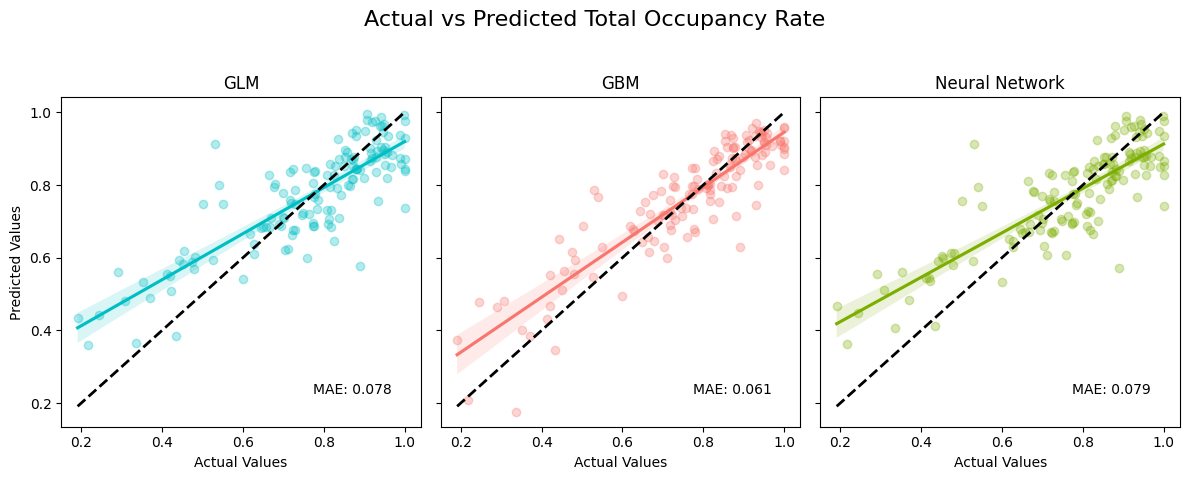

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

# GLM
sns.regplot(ax=axes[0], x=y_test, y=y_pred_glm, color='#00bfc4', scatter_kws={"alpha": 0.3})
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[0].set_title('GLM')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].annotate(f'MAE: {mae_glm:.3f}', xy=(0.7, 0.1), xycoords='axes fraction')

# GBM
sns.regplot(ax=axes[1], x=y_test, y=y_pred_gbm, color='#f8766d', scatter_kws={"alpha": 0.3})
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[1].set_title('GBM')
axes[1].set_xlabel('Actual Values')
axes[1].annotate(f'MAE: {mae_gbm:.3f}', xy=(0.7, 0.1), xycoords='axes fraction')

# Neural Network
sns.regplot(ax=axes[2], x=y_test, y=y_pred_nn, color='#7cae00', scatter_kws={"alpha": 0.3})
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[2].set_title('Neural Network')
axes[2].set_xlabel('Actual Values')
axes[2].annotate(f'MAE: {mae_nn:.3f}', xy=(0.7, 0.1), xycoords='axes fraction')

plt.suptitle('Actual vs Predicted Total Occupancy Rate', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


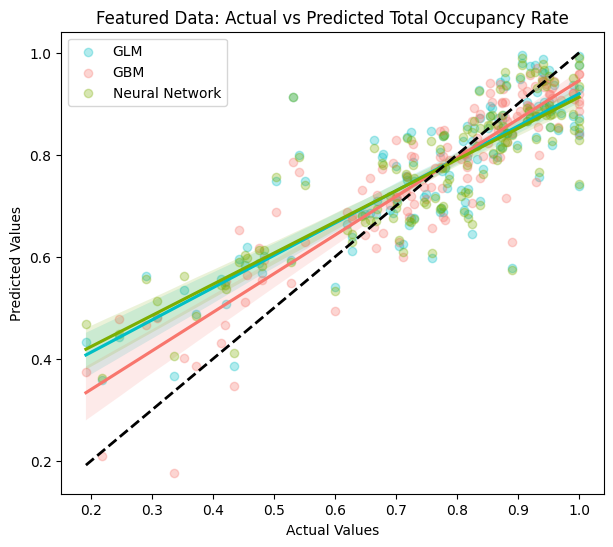

In [ ]:
# Plot predicted values vs actual values with regression line
plt.figure(figsize=(7, 6))

# GLM
sns.regplot(x=y_test, y=y_pred_glm, label="GLM", color='#00bfc4', scatter_kws={"alpha": 0.3})

# GBM
sns.regplot(x=y_test, y=y_pred_gbm, label="GBM", color='#f8766d', scatter_kws={"alpha": 0.3})

# Neural Network
sns.regplot(x=y_test, y=y_pred_nn, label="Neural Network", color='#7cae00', scatter_kws={"alpha": 0.3})

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('Featured Data: Actual vs Predicted Total Occupancy Rate')

# Add a dashed black line of y = x
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.show()

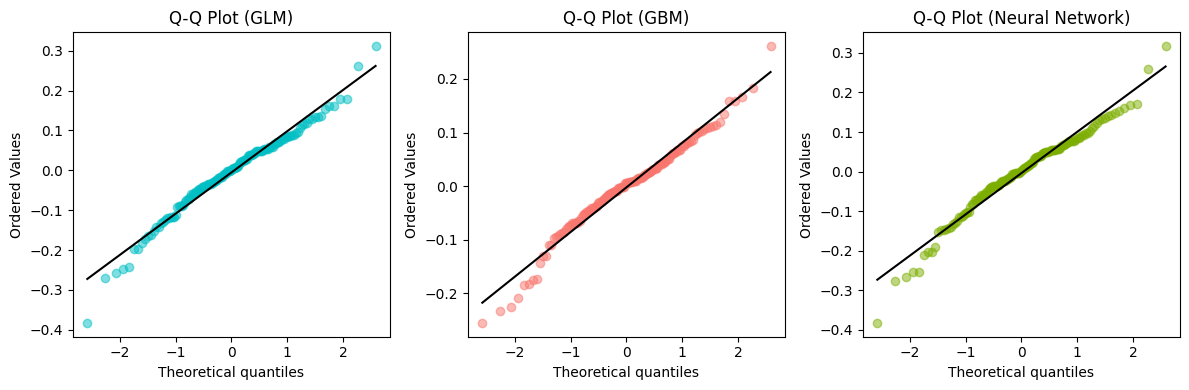

In [ ]:
# Calculate the residuals
residuals_glm = y_test - y_pred_glm
residuals_gbm = y_test - y_pred_gbm
residuals_nn = y_test - y_pred_nn

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Q-Q plot for GLM residuals
stats.probplot(residuals_glm, dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot (GLM)')
# Customize the points
axes[0].get_lines()[0].set_marker('o')
axes[0].get_lines()[0].set_markerfacecolor('#00bfc4')
axes[0].get_lines()[0].set_markeredgecolor('#00bfc4')
axes[0].get_lines()[0].set_alpha(0.5)
# Customize the Q-Q line
axes[0].get_lines()[1].set_color('black')

# Q-Q plot for GBM residuals
stats.probplot(residuals_gbm, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (GBM)')
# Customize the points
axes[1].get_lines()[0].set_marker('o')
axes[1].get_lines()[0].set_markerfacecolor('#f8766d')
axes[1].get_lines()[0].set_markeredgecolor('#f8766d')
axes[1].get_lines()[0].set_alpha(0.5)
# Customize the Q-Q line
axes[1].get_lines()[1].set_color('black')

# Q-Q plot for Neural Network residuals
stats.probplot(residuals_nn, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Neural Network)')
# Customize the points
axes[2].get_lines()[0].set_marker('o')
axes[2].get_lines()[0].set_markerfacecolor('#7cae00')
axes[2].get_lines()[0].set_markeredgecolor('#7cae00')
axes[2].get_lines()[0].set_alpha(0.5)
# Customize the Q-Q line
axes[2].get_lines()[1].set_color('black')

plt.tight_layout()
plt.show()

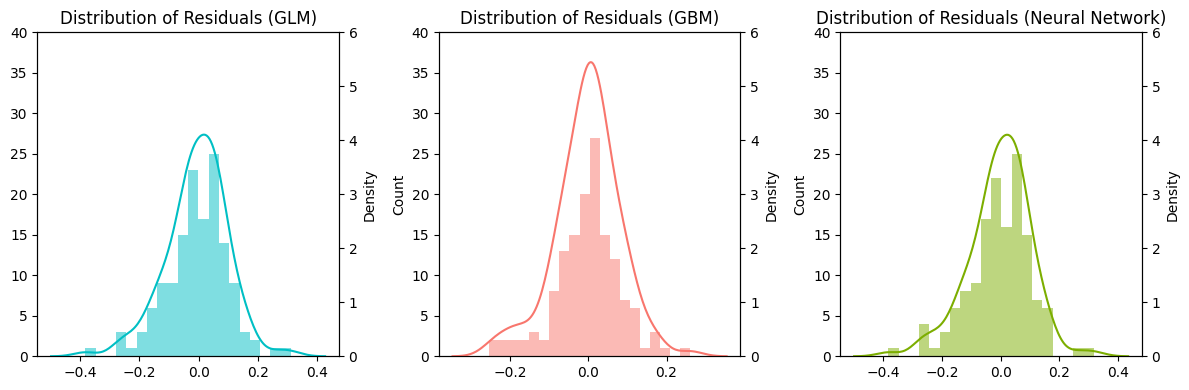

In [ ]:
# Create subplots for residual distribution
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Distribution of residuals for GLM
axes[0].hist(residuals_glm, bins=20, color='#00bfc4', alpha=0.5)
axes[0].set_ylim(0, 40)
axes[0].set_title('Distribution of Residuals (GLM)')
axes[0].spines['right'].set_visible(True)
axes[0].twinx().set_ylim(0, 6) 
sns.kdeplot(residuals_glm, color='#00bfc4')

# Distribution of residuals for GBM
axes[1].hist(residuals_gbm, bins=20, color='#f8766d', alpha=0.5)
axes[1].set_ylim(0, 40)
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Residuals (GBM)')
axes[1].spines['right'].set_visible(True)
axes[1].twinx().set_ylim(0, 6) 
sns.kdeplot(residuals_gbm, color='#f8766d')

# Distribution of residuals for Neural Network
axes[2].hist(residuals_nn, bins=20, color='#7cae00', alpha=0.5)
axes[2].set_ylim(0, 40)
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Residuals (Neural Network)')
axes[2].spines['right'].set_visible(True)
axes[2].twinx().set_ylim(0, 6) 
sns.kdeplot(residuals_nn, color='#7cae00')

plt.tight_layout()
plt.show()

# 2 Predict "Is-High-Occupancy"



## 2.1 Preprocess Data

In [ ]:
# Load the dataset
data = pd.read_csv('communities_db.csv')

# Split the dataset into features and target
# Remove TOC, IsHighOccupancy, categorical features and others
X = data.drop(columns=['TotalOccupancyRate', 'HouseNo1Bed', 'HouseNo2Bed', 'HouseNo3Bed', 
                       'NewHomeRate', 'Prop3Bed', 'IsHighOccupancy', 'Location', 'State',
                       'Popularity', 'IsLowPropDevi','IsNewDominant',])
y = data['IsHighOccupancy']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
numeric_features = ['TotalHouseNo', 'MedianPrice', 'Prop1Bed', 'Prop2Bed', 
                    'PropDevi', 'WeightedFreq', ]
categorical_features = [] 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## 2.2 Classification Model

### 2.2.1 GLM Logistic Regression

In [ ]:
# GLM
glm_model = LogisticRegression(random_state=42)
glm_model.fit(X_train, y_train)

# Make binary predictions for GLM
y_pred_glm_proba = glm_model.predict(X_test)
y_pred_glm = np.round(y_pred_glm_proba).flatten()

### 2.2.2 GBM Classification

In [ ]:
# GBM
gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train, y_train)

# Make binary predictions for GBM
y_pred_gbm_proba = gbm_model.predict(X_test)
y_pred_gbm = np.round(y_pred_gbm_proba).flatten()

### 2.2.3 Neural Network, Binary, Cross Entropy Loss

In [ ]:
def create_nn_model():
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' activation for binary classification
    #model.add(Dense(1, activation='tanh'))  # Use 'tanh' activation for binary classification

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])  # Use 'binary_crossentropy' loss for binary classification
    return model

# Train the neural network model
nn_model = create_nn_model()
history = nn_model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# Make predictions on the test set
y_pred_nn_proba = nn_model.predict(X_test)
y_pred_nn = np.round(y_pred_nn_proba).flatten()  # Convert probabilities to binary predictions

5/5 [==============================] - 0s 3ms/step


0.8943661971830986

### 2.2.4 SVM Classification

In [ ]:
# SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Make binary predictions for SVM
y_pred_svm_proba = svm_model.predict_proba(X_test)[:, 1]
y_pred_svm = svm_model.predict(X_test)

### 2.2.5 XGB Classification

In [ ]:
# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make binary predictions for XGBoost
y_pred_xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


## 2.3 Model Evaluation

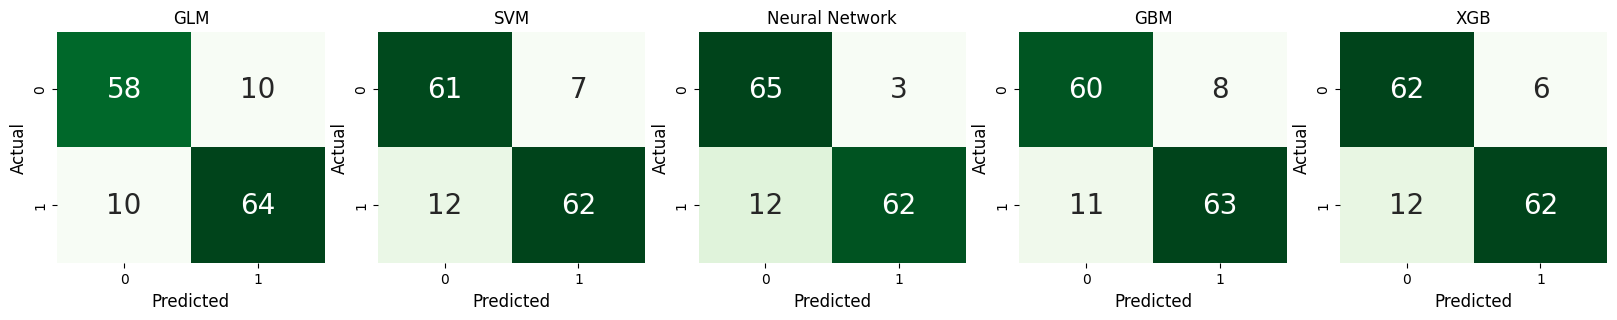

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title, ax, fontsize=12, annot_size=20):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax, annot_kws={"size": annot_size})
    ax.set_xlabel('Predicted', fontsize=fontsize)
    ax.set_ylabel('Actual', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)

# Adjust the figure and subplots parameters
fig, axs = plt.subplots(1, 5, figsize=(20, 3))

# Plot confusion matrices
plot_confusion_matrix(y_test, y_pred_glm, 'GLM', axs[0])
plot_confusion_matrix(y_test, y_pred_svm, 'SVM', axs[1])
plot_confusion_matrix(y_test, y_pred_nn, 'Neural Network', axs[2])
plot_confusion_matrix(y_test, y_pred_gbm, 'GBM', axs[3])
plot_confusion_matrix(y_test, y_pred_xgb, 'XGB', axs[4])

plt.show()

In [ ]:
# Calculate accuracy and F1-score for GLM
accuracy_glm = accuracy_score(y_test, y_pred_glm)
f1_glm = f1_score(y_test, y_pred_glm)

# Calculate accuracy and F1-score for GBM
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
f1_gbm = f1_score(y_test, y_pred_gbm)

# Calculate accuracy and F1-score for Neural Network
accuracy_nn = accuracy_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)

# Calculate accuracy and F1-score for SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

# Calculate accuracy and F1-score for XGB
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)


print("Model  Accuracy  F1-score")
print("-------------------------")
print(f"GLM\t{accuracy_glm:.3f}\t  {f1_glm:.3f}")
print(f"SVM\t{accuracy_svm:.3f}\t  {f1_svm:.3f}")
print(f"GBM\t{accuracy_gbm:.3f}\t  {f1_gbm:.3f}")
print(f"XGB\t{accuracy_xgb:.3f}\t  {f1_xgb:.3f}")
print(f"NNW\t{accuracy_nn:.3f}\t  {f1_nn:.3f}")

Model  Accuracy  F1-score
-------------------------
GLM	0.859	  0.865
SVM	0.866	  0.867
GBM	0.866	  0.869
XGB	0.873	  0.873
NNW	0.894	  0.892


# 3 Regression Model without Feature Engineering

In [ ]:
# Load the dataset
data = pd.read_csv('communities.csv')

# Drop rows with missing values
data = data.dropna()

# Split the dataset into features and target
X = data.drop(columns=['TotalOccupancyRate', 'CommunityID'])
# Perform Box Cox Transformation
y = data['TotalOccupancyRate']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
numeric_features = ['MedianPrice', 'TotalHouseNo', 'HouseNo1Bed', 'HouseNo2Bed', 'HouseNo3Bed', 'NewHomeRate']
categorical_features = ['Location', 'State']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [ ]:
# GLM
glm_model = LinearRegression()
glm_model.fit(X_train, y_train)
y_pred_glm = glm_model.predict(X_test)

# Calculate MSE, MAE, and Correlation Coefficient
mse_glm = mean_squared_error(y_test, y_pred_glm)
mae_glm = mean_absolute_error(y_test, y_pred_glm)
corr_coeff_glm = np.corrcoef(y_test, y_pred_glm)[0, 1]

print(f"GLM: MSE = {mse_glm:.3f}, MAE = {mae_glm:.3f}, Correlation Coefficient = {corr_coeff_glm:.3f}")

GLM: MSE = 0.017, MAE = 0.100, Correlation Coefficient = 0.563


In [ ]:
# GBM
gbm_model = GradientBoostingRegressor(random_state=42)
gbm_model.fit(X_train, y_train)
y_pred_gbm = gbm_model.predict(X_test)

# Calculate MSE, MAE, and Correlation Coefficient
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
mae_gbm = mean_absolute_error(y_test, y_pred_gbm)
corr_coeff_gbm = np.corrcoef(y_test, y_pred_gbm)[0, 1]

print(f"GBM: MSE = {mse_gbm:.3f}, MAE = {mae_gbm:.3f}, Correlation Coefficient = {corr_coeff_gbm:.3f}")

GBM: MSE = 0.006, MAE = 0.057, Correlation Coefficient = 0.863


In [ ]:
# Neural Network with cross-validation
def create_nn_model(input_shape=X_train.shape[1]):
    model = Sequential()
    model.add(Dense(32, activation='linear', input_shape=(input_shape,)))
    model.add(Dense(16, activation='linear'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Neural Network with cross-validation
nn_model_cv = KerasRegressor(build_fn=create_nn_model, batch_size=64, epochs=50, verbose=0, shuffle=False)
nn_model_cv.fit(X_train, y_train, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])
y_pred_nn = nn_model_cv.predict(X_test)

# Calculate MSE, MAE, and Correlation Coefficient
mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
corr_coeff_nn = np.corrcoef(y_test, y_pred_nn)[0, 1]

print(f"Neural Network: MSE = {mse_nn:.3f}, MAE = {mae_nn:.3f}, Correlation Coefficient = {corr_coeff_nn:.3f}")

<ipython-input-368-2c5581cfb3bb>:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model_cv = KerasRegressor(build_fn=create_nn_model, batch_size=64, epochs=50, verbose=0, shuffle=False)


Neural Network: MSE = 0.017, MAE = 0.100, Correlation Coefficient = 0.560


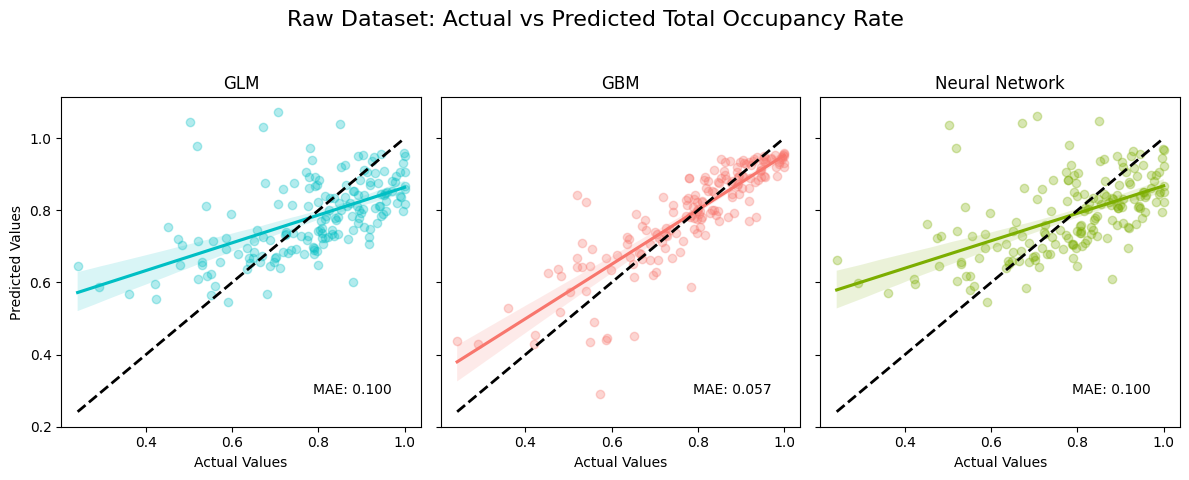

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

# GLM
sns.regplot(ax=axes[0], x=y_test, y=y_pred_glm, color='#00bfc4', scatter_kws={"alpha": 0.3})
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[0].set_title('GLM')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].annotate(f'MAE: {mae_glm:.3f}', xy=(0.7, 0.1), xycoords='axes fraction')

# GBM
sns.regplot(ax=axes[1], x=y_test, y=y_pred_gbm, color='#f8766d', scatter_kws={"alpha": 0.3})
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[1].set_title('GBM')
axes[1].set_xlabel('Actual Values')
axes[1].annotate(f'MAE: {mae_gbm:.3f}', xy=(0.7, 0.1), xycoords='axes fraction')

# Neural Network
sns.regplot(ax=axes[2], x=y_test, y=y_pred_nn, color='#7cae00', scatter_kws={"alpha": 0.3})
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[2].set_title('Neural Network')
axes[2].set_xlabel('Actual Values')
axes[2].annotate(f'MAE: {mae_nn:.3f}', xy=(0.7, 0.1), xycoords='axes fraction')

plt.suptitle('Raw Dataset: Actual vs Predicted Total Occupancy Rate', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

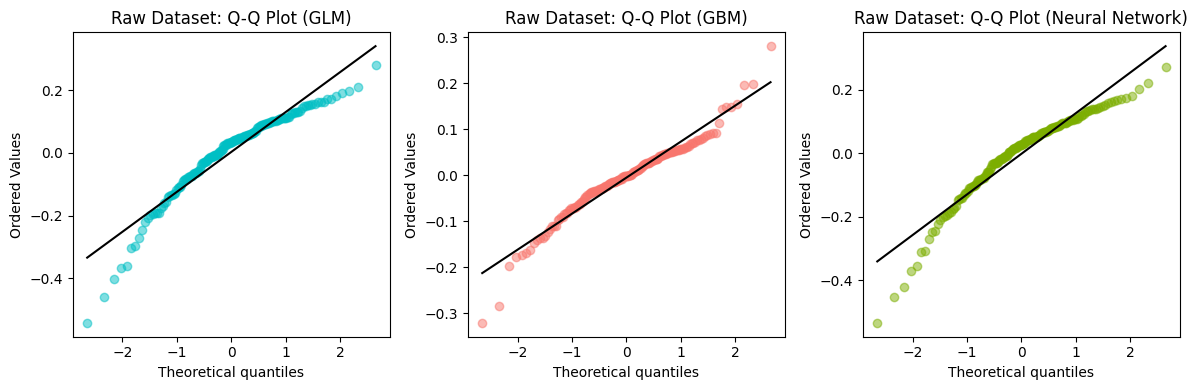

In [ ]:
# Calculate the residuals
residuals_glm = y_test - y_pred_glm
residuals_gbm = y_test - y_pred_gbm
residuals_nn = y_test - y_pred_nn

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Q-Q plot for GLM residuals
stats.probplot(residuals_glm, dist="norm", plot=axes[0])
axes[0].set_title('Raw Dataset: Q-Q Plot (GLM)')
# Customize the points
axes[0].get_lines()[0].set_marker('o')
axes[0].get_lines()[0].set_markerfacecolor('#00bfc4')
axes[0].get_lines()[0].set_markeredgecolor('#00bfc4')
axes[0].get_lines()[0].set_alpha(0.5)
# Customize the Q-Q line
axes[0].get_lines()[1].set_color('black')

# Q-Q plot for GBM residuals
stats.probplot(residuals_gbm, dist="norm", plot=axes[1])
axes[1].set_title('Raw Dataset: Q-Q Plot (GBM)')
# Customize the points
axes[1].get_lines()[0].set_marker('o')
axes[1].get_lines()[0].set_markerfacecolor('#f8766d')
axes[1].get_lines()[0].set_markeredgecolor('#f8766d')
axes[1].get_lines()[0].set_alpha(0.5)
# Customize the Q-Q line
axes[1].get_lines()[1].set_color('black')

# Q-Q plot for Neural Network residuals
stats.probplot(residuals_nn, dist="norm", plot=axes[2])
axes[2].set_title('Raw Dataset: Q-Q Plot (Neural Network)')
# Customize the points
axes[2].get_lines()[0].set_marker('o')
axes[2].get_lines()[0].set_markerfacecolor('#7cae00')
axes[2].get_lines()[0].set_markeredgecolor('#7cae00')
axes[2].get_lines()[0].set_alpha(0.5)
# Customize the Q-Q line
axes[2].get_lines()[1].set_color('black')

plt.tight_layout()
plt.show()

# 4 Unused & Optional

## 3.1 Preprocess Data

In [ ]:
# Load the dataset
data = pd.read_csv('communities_db.csv')

# Split the dataset into features and target
# Remove TOC, IsHighOccupancy, categorical features and others
X = data.drop(columns=['TotalOccupancyRate', 'HouseNo1Bed', 'HouseNo3Bed', 'MedianPrice',
                       'Prop3Bed', 'IsHighOccupancy', 'Popularity',])
y = data['MedianPrice']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
numeric_features = ['TotalHouseNo',  'HouseNo2Bed', 'Prop1Bed', 'Prop2Bed', 'PropDevi', 
                    'WeightedFreq', 'NewHomeRate', 'IsLowPropDevi', 'IsNewDominant']
categorical_features = ['Location','State',] 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## 3.2 Regression Models

In [ ]:
# GLM
glm_model = LinearRegression()
glm_model.fit(X_train, y_train)
y_pred_glm = glm_model.predict(X_test)

# Calculate MSE, MAE, and Correlation Coefficient
mse_glm = mean_squared_error(y_test, y_pred_glm)
mae_glm = mean_absolute_error(y_test, y_pred_glm)
corr_coeff_glm = np.corrcoef(y_test, y_pred_glm)[0, 1]

print(f"GLM: MSE = {mse_glm:.3f}, MAE = {mae_glm:.3f}, Correlation Coefficient = {corr_coeff_glm:.3f}")

GLM: MSE = 8920406572.217, MAE = 74421.318, Correlation Coefficient = 0.586


In [ ]:
# GBM
gbm_model = GradientBoostingRegressor(random_state=42)
gbm_model.fit(X_train, y_train)
y_pred_gbm = gbm_model.predict(X_test)

# Calculate MSE, MAE, and Correlation Coefficient
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
mae_gbm = mean_absolute_error(y_test, y_pred_gbm)
corr_coeff_gbm = np.corrcoef(y_test, y_pred_gbm)[0, 1]

print(f"GBM: MSE = {mse_gbm:.3f}, MAE = {mae_gbm:.3f}, Correlation Coefficient = {corr_coeff_gbm:.3f}")

GBM: MSE = 3606331492.464, MAE = 46247.833, Correlation Coefficient = 0.875


In [ ]:
# Neural Network with cross-validation
def create_nn_model(input_shape=X_train.shape[1]):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(input_shape,)))
    model.add(Dense(16, activation='linear'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.1), loss='mse', metrics=['mae'])
    return model

# Neural Network with cross-validation
nn_model_cv = KerasRegressor(build_fn=create_nn_model, batch_size=32, epochs=200, verbose=0)
nn_model_cv.fit(X_train, y_train, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])
y_pred_nn = nn_model_cv.predict(X_test)

# Calculate MSE, MAE, and Correlation Coefficient
mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
corr_coeff_nn = np.corrcoef(y_test, y_pred_nn)[0, 1]

print(f"Neural Network: MSE = {mse_nn:.3f}, MAE = {mae_nn:.3f}, Correlation Coefficient = {corr_coeff_nn:.3f}")

<ipython-input-94-e338c67bd6a1>:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model_cv = KerasRegressor(build_fn=create_nn_model, batch_size=32, epochs=200, verbose=0)


Neural Network: MSE = 4123155954.653, MAE = 49662.603, Correlation Coefficient = 0.858


## 3.3 Model Evaluation

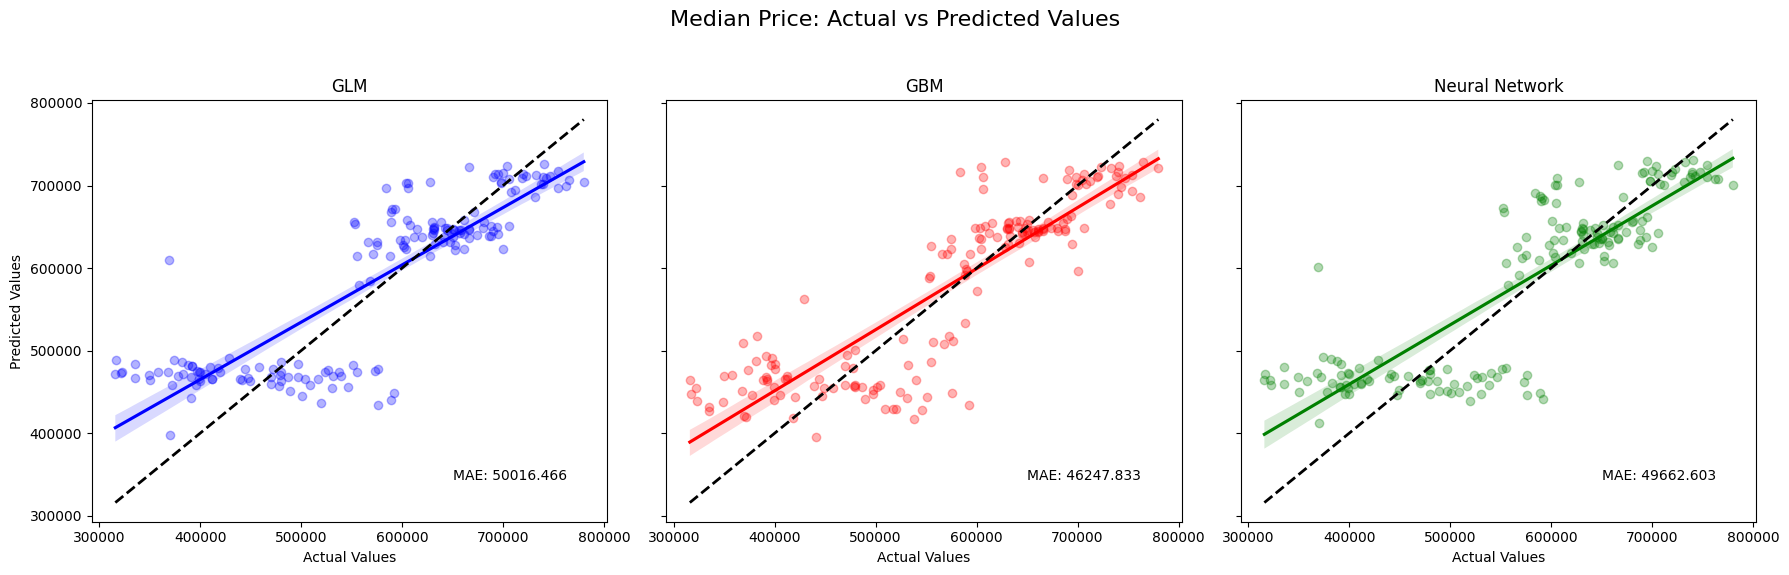

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# GLM
sns.regplot(ax=axes[0], x=y_test, y=y_pred_glm, color='blue', scatter_kws={"alpha": 0.3})
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[0].set_title('GLM')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].annotate(f'MAE: {mae_glm:.3f}', xy=(0.7, 0.1), xycoords='axes fraction')

# GBM
sns.regplot(ax=axes[1], x=y_test, y=y_pred_gbm, color='red', scatter_kws={"alpha": 0.3})
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[1].set_title('GBM')
axes[1].set_xlabel('Actual Values')
axes[1].annotate(f'MAE: {mae_gbm:.3f}', xy=(0.7, 0.1), xycoords='axes fraction')

# Neural Network
sns.regplot(ax=axes[2], x=y_test, y=y_pred_nn, color='green', scatter_kws={"alpha": 0.3})
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[2].set_title('Neural Network')
axes[2].set_xlabel('Actual Values')
axes[2].annotate(f'MAE: {mae_nn:.3f}', xy=(0.7, 0.1), xycoords='axes fraction')

plt.suptitle('Median Price: Actual vs Predicted Values', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

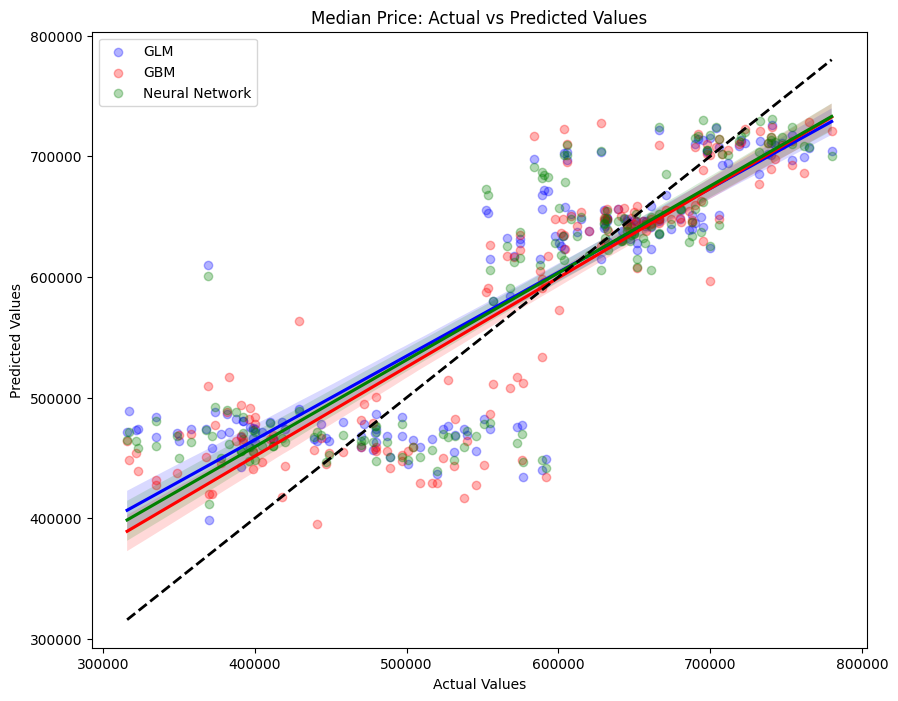

In [ ]:
# Plot predicted values vs actual values with regression line
plt.figure(figsize=(10, 8))

# GLM
sns.regplot(x=y_test, y=y_pred_glm, label="GLM", color='blue', scatter_kws={"alpha": 0.3})

# GBM
sns.regplot(x=y_test, y=y_pred_gbm, label="GBM", color='red', scatter_kws={"alpha": 0.3})

# Neural Network
sns.regplot(x=y_test, y=y_pred_nn, label="Neural Network", color='green', scatter_kws={"alpha": 0.3})

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('Median Price: Actual vs Predicted Values')

# Add a dashed black line of y = x
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.show()

In [ ]:
# Load the dataset
data = pd.read_csv('communities_featured.csv')

# Split the dataset into features and target
# Occupancy is unknown
X = data.drop(columns=['TotalOccupancyRate', 'IsHighOccupancy'])
y = data['TotalOccupancyRate']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
numeric_features = ['MedianPrice', 'TotalHouseNo', 'HouseNo1Bed', 'HouseNo2Bed', 'HouseNo3Bed', 
                    'Prop1Bed', 'Prop2Bed', 'Prop3Bed', 'PropDevi', 'NewHomeRate']
categorical_features = ['Location', 'State', 'IsBestProp', 'IsNewDominant', 'IsCoastal', 'IsRegional']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [ ]:
# Load the dataset
data = pd.read_csv('communities_featured.csv')

# Split the dataset into features and target
# Occupancy is unknown
X = data.drop(columns=['TotalOccupancyRate', 'IsHighOccupancy'])
y = data['IsHighOccupancy']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
numeric_features = ['MedianPrice', 'TotalHouseNo', 'HouseNo1Bed', 'HouseNo2Bed', 'HouseNo3Bed', 'Prop1Bed', 'Prop2Bed', 'Prop3Bed', 'PropDevi', 'NewHomeRate']
categorical_features = ['Location', 'State', 'IsBestProp', 'IsNewDominant', 'IsCoastal', 'IsRegional']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Convert the target variable to numerical format
y_train_num = y_train.replace({"Yes": 1, "No": 0})
y_test_num = y_test.replace({"Yes": 1, "No": 0})

In [ ]:
# Load the dataset
data = pd.read_csv('communities_featured.csv')

# Split the dataset into features and target
X = data.drop(columns=['MedianPrice'])
y = data['MedianPrice']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
numeric_features = ['TotalOccupancyRate', 'TotalHouseNo', 'HouseNo1Bed', 'HouseNo2Bed', 'HouseNo3Bed', 'Prop1Bed', 'Prop2Bed', 'Prop3Bed', 'PropDevi', 'NewHomeRate']
categorical_features = ['Location', 'State', 'IsBestProp', 'IsNewDominant', 'IsCoastal', 'IsRegional', 'IsHighOccupancy']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)